In [6]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import model as dl
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def test(i, loader, neural_network):
    acc = 0
    results_sum = []
    labels_test_sum = []
    results_PR_sum = []
    for step, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device)
        # 前向传播
        outputs = neural_network(data.float())
        acc += outputs.argmax(dim=1).eq(labels).float().mean().item()
        results_sum.extend(outputs.argmax(dim=1).cpu().numpy())
        labels_test_sum.extend(labels.cpu().numpy())
        results_PR_sum.extend(outputs.detach().cpu().numpy())
    acc_average = acc / (step + 1)
    print("第" + str(i + 1) + "次训练测试集准确率: {:.4f}".format(acc_average))
    return acc_average, results_sum, labels_test_sum, results_PR_sum

In [8]:
name = locals()
seed = 34
dl.seed_everything(seed)
model_type = 'STCGRU'
batch_size = 256
total_fold = 10  # 10折

test_acc_sum = 0
results_sum = []
labels_test_sum = []
results_PR_sum = []
# 定义脑区索引
from itertools import combinations

# 初始脑区定义
regions = {
    "prefrontal": [0, 1, 2, 3, 10, 11, 16],
    "central": [4, 5, 17],
    "temporal": [12, 13, 14, 15],
    "parietal": [6, 7, 18],
    "occipital": [8, 9]
}

# 自动生成多脑区组合
def generate_combinations(regions, sizes):
    combined_regions = {}
    region_names = list(regions.keys())
    # 遍历指定组合大小
    for size in sizes:
        for combination in combinations(region_names, size):
            combined_name = "_".join(combination)  # 组合名称
            combined_indices = sorted(set().union(*(regions[region] for region in combination)))  # 合并去重
            combined_regions[combined_name] = combined_indices
    return combined_regions
# 生成所有二、三、四脑区组合
regions = generate_combinations(regions, sizes=[1,2, 3, 4,5])
# 动态获取变量值
partition = "prefrontal_occipital"


dataset_name = "stcgru_tnb_raw"
for i in range(total_fold):
    test_data_combine = torch.load("EEGDataTNBRaw/"+partition+"/TestData/test_data_"+ str(i + 1) + "_fold_with_seed_" + str(seed) + ".pth", weights_only=False)
    test_loader = DataLoader(dataset=test_data_combine,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=8)

    model = dl.STCGRU(len(regions[partition])).to(device)
    model_loc =  dataset_name+'/'+partition+"/"+str(i + 1) + "_fold_model_parameter_with_seed_" + str(seed) + ".pth"
    model_dict = torch.load(model_loc,weights_only=True)
    model.load_state_dict(model_dict)
    '''测试'''
    acc_average, results, labels_test, results_PR = test(i, loader=test_loader, neural_network=model)

    results_sum = np.append(results_sum, results)
    labels_test_sum = np.append(labels_test_sum, labels_test)
    results_PR_sum.extend(results_PR)
    name['test_acc_average_' + str(i + 1)] = acc_average

    confusion_matrix_single = confusion_matrix(labels_test, results, labels=[0, 1])
    kappa_single = cohen_kappa_score(labels_test, results)
    sensitivity_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[0, 1])  # 灵敏度（召回率）
    specificity_single = confusion_matrix_single[1, 1] / (confusion_matrix_single[1, 1] + confusion_matrix_single[1, 0])  # 特异度
    precision_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[1, 0])  # 查准率
    F1_single = 2 * precision_single * sensitivity_single / (precision_single + sensitivity_single)  # F1值
    print(model_type + " 第%d折交叉验证测试集准确率: %.4f，kappa值：%.4f，灵敏度：%.4f，特异度：%.4f，查准率：%.4f，F1值：%.4f"
        % (i+1, acc_average, kappa_single, sensitivity_single, specificity_single, precision_single, F1_single))
for i in range(total_fold):
    if i == 0:
        test_acc_sum = name['test_acc_average_' + str(i + 1)]
    else:
        test_acc_sum = np.append(test_acc_sum, name['test_acc_average_' + str(i + 1)])
    del name['test_acc_average_' + str(i + 1)]

第1次训练测试集准确率: 0.7476
STCGRU 第1折交叉验证测试集准确率: 0.7476，kappa值：0.4880，灵敏度：0.7745，特异度：0.7173，查准率：0.7004，F1值：0.7356
第2次训练测试集准确率: 0.9968
STCGRU 第2折交叉验证测试集准确率: 0.9968，kappa值：0.9943，灵敏度：1.0000，特异度：0.9948，查准率：0.9939，F1值：0.9969
第3次训练测试集准确率: 0.9967
STCGRU 第3折交叉验证测试集准确率: 0.9967，kappa值：0.9929，灵敏度：1.0000，特异度：0.9936，查准率：0.9922，F1值：0.9961
第4次训练测试集准确率: 0.9850
STCGRU 第4折交叉验证测试集准确率: 0.9850，kappa值：0.9673，灵敏度：0.9831，特异度：0.9843，查准率：0.9816，F1值：0.9824
第5次训练测试集准确率: 0.9923
STCGRU 第5折交叉验证测试集准确率: 0.9923，kappa值：0.9843，灵敏度：0.9952，特异度：0.9898，查准率：0.9874，F1值：0.9913
第6次训练测试集准确率: 0.5586
STCGRU 第6折交叉验证测试集准确率: 0.5586，kappa值：0.0000，灵敏度：0.0000，特异度：1.0000，查准率：nan，F1值：nan


C:\Users\31017\AppData\Local\Temp\ipykernel_28444\3928542370.py:67: RuntimeWarning: invalid value encountered in scalar divide
  precision_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[1, 0])  # 查准率


第7次训练测试集准确率: 0.7636
STCGRU 第7折交叉验证测试集准确率: 0.7636，kappa值：0.5304，灵敏度：0.7461，特异度：0.7849，查准率：0.7379，F1值：0.7420
第8次训练测试集准确率: 0.9845
STCGRU 第8折交叉验证测试集准确率: 0.9845，kappa值：0.9687，灵敏度：0.9771，特异度：0.9908，查准率：0.9892，F1值：0.9831
第9次训练测试集准确率: 0.5588
STCGRU 第9折交叉验证测试集准确率: 0.5588，kappa值：0.0000，灵敏度：0.0000，特异度：1.0000，查准率：nan，F1值：nan


C:\Users\31017\AppData\Local\Temp\ipykernel_28444\3928542370.py:67: RuntimeWarning: invalid value encountered in scalar divide
  precision_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[1, 0])  # 查准率


第10次训练测试集准确率: 0.7762
STCGRU 第10折交叉验证测试集准确率: 0.7762，kappa值：0.5513，灵敏度：0.7785，特异度：0.7752，查准率：0.7415，F1值：0.7595


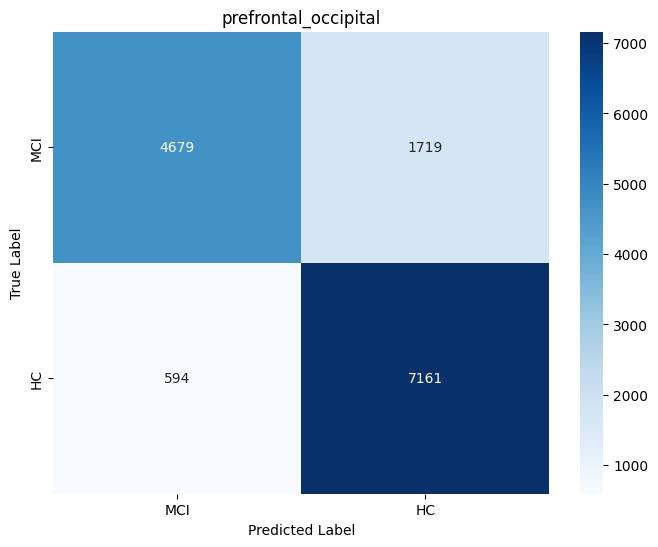

STCGRU 10折交叉验证平均测试集准确率: 0.8360 ± 0.1705，kappa值：0.6650，灵敏度：0.7313，特异度：0.9234，查准率：0.8874，F1值：0.8018


In [9]:
test_acc_final = np.sum(test_acc_sum) / total_fold
test_acc_std = float(np.std(test_acc_sum))
confusion_matrix = confusion_matrix(labels_test_sum, results_sum, labels=[0, 1])
import seaborn as sns
kappa = cohen_kappa_score(labels_test_sum, results_sum)
sensitivity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])  # 灵敏度（召回率）
specificity = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])  # 特异度
precision = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[1, 0])  # 查准率
F1 = 2 * precision * sensitivity / (precision + sensitivity)  # F1值
def plot_confusion_matrix(confusion_matrix, classes, title='Confusion Matrix of SVM'):
    # 计算混淆矩阵
    
    # 创建热力图
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    # 设置标题和标签
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
plot_confusion_matrix(confusion_matrix, classes=['MCI', 'HC'],title=partition)
print(model_type + " %d折交叉验证平均测试集准确率: %.4f ± %.4f，kappa值：%.4f，灵敏度：%.4f，特异度：%.4f，查准率：%.4f，F1值：%.4f"
    % (total_fold, test_acc_final, test_acc_std, kappa, sensitivity, specificity, precision, F1))
